In [5]:
import matplotlib.pyplot as plt
import polars as pl
from util.data import load_data
from sklearn.model_selection import train_test_split

In [40]:
df = load_data().fetch(300_000)

In [41]:
train, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train, test_size=0.2)

In [42]:
type(train['pickup_latitude'])

polars.internals.series.series.Series

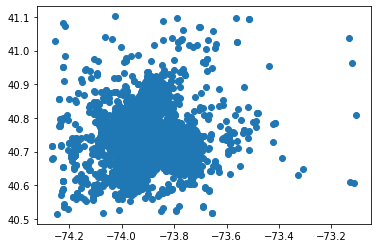

In [43]:
y = train['pickup_latitude'].append(train['dropoff_latitude'])
x = train['pickup_longitude'].append(train['dropoff_longitude'])
plt.plot(x, y, 'o')